In [1]:
import os
import pandas as pd
from torch import nn
import torch
from torch.utils import data
import d2l.torch as d2l
from sklearn.metrics import confusion_matrix

In [2]:
def get_dataloader_workers():
    return 4

def load_array(data_arrays, bathch_size, istrain):
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, bathch_size, shuffle=istrain)

def readfolder(foldername, batch_size, istrain):
    all_label = None
    all_feature = None
    for filename in os.listdir(foldername):
        excelname = os.path.join(foldername, filename)
        file = pd.read_excel(excelname)
        label = torch.tensor(file.iloc[:,0].values)
        feature = torch.tensor(file.iloc[:,1:].values, dtype=torch.float32)
        if all_label is None:
            all_label = label
        else:
            all_label = torch.cat((all_label, label), dim=0)
        if all_feature is None:
            all_feature = feature
        else:
            all_feature = torch.cat((all_feature, feature), dim=0)
    return load_array((all_feature, all_label), batch_size, istrain)

def get_train(batch_size):
    feature = torch.tensor(pd.read_csv('train_feature.csv', header=None).values, dtype=torch.float32)
    label = torch.tensor(pd.read_csv('train_label.csv', header=None).values, dtype=torch.int64)
    return load_array((feature, label.reshape(-1)), batch_size, True)

def get_test(batch_size):
    feature = torch.tensor(pd.read_csv('test_feature.csv', header=None).values, dtype=torch.float32)
    label = torch.tensor(pd.read_csv('test_label.csv', header=None).values, dtype=torch.int64)
    return load_array((feature, label.reshape(-1)), batch_size, False)

In [3]:
batch_size = 32
train_iter = get_train(batch_size)
test_iter = get_test(batch_size)

In [4]:
X, _ = next(iter(train_iter))
input_size = X.shape[1]

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

net = nn.Sequential(
    nn.Linear(input_size, 256), nn.ReLU(),
    nn.Linear(256, 128), nn.ReLU(),
    nn.Linear(128, 64), nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.Linear(64, 64), nn.ReLU(),
    nn.Linear(64, 64), nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.Linear(64, 64), nn.ReLU(),
    nn.Linear(64, 32), nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.Linear(32, 8), nn.ReLU(),
    nn.Linear(8, 7)
)

net.apply(init_weights)
net = net.to(device=d2l.try_gpu())

In [5]:
learning_rate = 0.1
trainer = torch.optim.SGD(net.parameters(), lr=learning_rate)
loss = nn.CrossEntropyLoss(reduction='none')

In [6]:
def train_epoch(net, train_iter, loss, updater):
    net.train()
    metric = d2l.Accumulator(3)
    for X, y in train_iter:
        X = X.to(device=d2l.try_gpu())
        y = y.to(device=d2l.try_gpu())
        y_hat = net(X)
        l = loss(y_hat, y)
        updater.zero_grad()
        l.mean().backward()
        updater.step()
        metric.add(float(l.sum()), d2l.accuracy(y_hat, y), y.numel())
    return metric[0] / metric[2], metric[1] / metric[2]

def train(net, train_iter, test_iter, loss, num_epochs, updater):
    net.apply(init_weights)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1.0], legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch(net, train_iter, loss, updater)
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch+1, train_metrics + (test_acc,))
        ans = train_metrics + (test_acc,)
    print(f'train acc is {train_metrics[1]:.4f}\n test acc is {test_acc:.4f}')
    return (train_metrics[1], test_acc)

train acc is 0.8348
 test acc is 0.6969


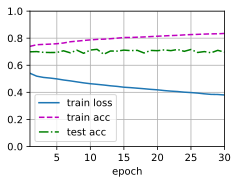

In [7]:
num_epochs = 30
train_acc, test_acc = train(net, train_iter, test_iter, loss, num_epochs, trainer)

1 为正类, 0 为负类

In [8]:
test_feature = pd.read_csv('test_feature.csv', header=None).values
y = pd.read_csv('test_label.csv', header=None).values.reshape(-1)
y_hat = net(torch.tensor(test_feature, device=d2l.try_gpu(), dtype=torch.float32)).cpu().detach().numpy()
y_hat = y_hat.argmax(axis=1)
Ans = confusion_matrix(y, y_hat, labels=None, sample_weight=None)
Ans[0,0], Ans[1,1] = Ans[1,1], Ans[0,0]
Ans[0,1], Ans[1,0] = Ans[1,0], Ans[0,1]
TP, FP, FN, TN = Ans[0,0], Ans[0,1], Ans[1,0], Ans[1,1]
precision = TP / (TP + FP)
recall = TP / (TP + FN) # Sensitivity
f1_score = 2 * precision * recall / (precision + recall)
specificity = TN / (TN + FP)

In [9]:
print(f'  train acc : {train_acc:.4f}')
print(f'   test acc : {test_acc:.4f}')
print(f'     recall : {recall:.4f}')
print(f'   f1 score : {f1_score:.4f}')
print(f'specificity : {specificity:.4f}')

  train acc : 0.8348
   test acc : 0.6969
     recall : 0.6255
   f1 score : 0.6619
specificity : 0.7613
